# IMDB review classification

Load the data set, limiting ourselves to only the 10,000 most-often used words:

In [1]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Using TensorFlow backend.


The first review seems positive (the `-3` is there because word indices 0, 1 and 2 have special meaning):

In [2]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [81]:
' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

Perform one-hot encoding of each review, being a single sequence of word indices.

Note that `results[i, [1, 8, 24]] = 1.` sets `results[i, 1]`, `results[i, 8]` and `results[i, 24]` all to one.

In [4]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test  = vectorize_sequences(test_data)

Convert the targets to floats, a 0 being a negative review and a 1 a positive one.

In [5]:
y_train = np.asarray(train_labels).astype('float32')
y_test  = np.asarray(test_labels).astype('float32')

Set apart part of the training set for validation: we train on the remaining training data, and use the validation data to figure out how well we are doing.

In [16]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

The model:
- The original model with two hidden layers of 16 neurons each, was overfitting the data greatly. A single layer with just 8 neurons limits that.
- Replacing the original `relu` activation by `tanh` increased its accuracy on the validation set.
- However, after epoch 7 the model still started to overfit, although much less than before, so limiting the epochs was another useful thing to do.

In [87]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(8, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=7,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=0)

The validation loss reaches its minimum at epoch 7, and would only have gone back up again had we trained further epochs:

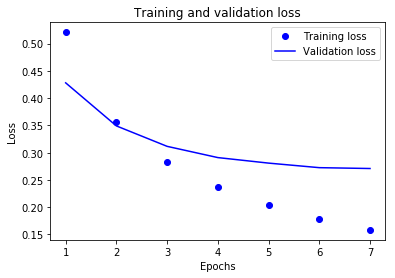

In [90]:
%matplotlib inline

import matplotlib.pyplot as plt

history_dict = history.history
loss_values     = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values      = history_dict['acc']
val_acc_values  = history_dict['val_acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values,     'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b',  label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Similar for the accuracy on the validation set:

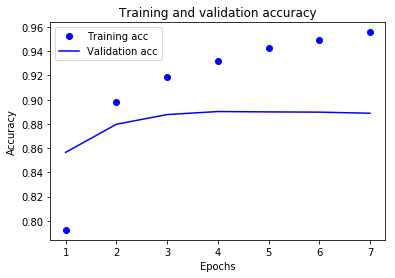

In [91]:
plt.clf()
plt.plot(epochs, acc_values,     'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b',  label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Evaluating the trained model in the unseen test set shows a loss of 0.29 and an accuracy of 88%:

In [92]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 4s 152us/step


[0.291256541929245, 0.8812]

Let's predict what the algorithm thinks of the first ten reviews. It's:

- pretty certain that some are positive (second review, with a score of 0.99)
- or negative (eight review, with a score of 0.04)
- yet not sure about others (fourth review, with a score of 0.67)

In [94]:
model.predict(x_test[:10])

array([[0.22311653],
       [0.99176276],
       [0.79214364],
       [0.68614656],
       [0.8994592 ],
       [0.82634383],
       [0.9810021 ],
       [0.03657003],
       [0.88945574],
       [0.96873045]], dtype=float32)